## Figure 1 | A curated spatial transcriptomic resource for the adult mouse thalamus.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import sys
sys.path.append('/code/')
from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import ccf_plots as cplots
from thalamus_merfish_analysis import ccf_erode as cerode

from matplotlib import rcParams
rcParams['ps.fonttype'] = 42
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 7

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline') 

In [3]:
results_dir = '../../results'

## Load thalamus data

In [4]:
obs_wmb = abc.get_combined_metadata()
obs_th = abc.load_standard_thalamus(data_structure='obs')

In [5]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'

x_col = 'x'+coords
y_col = 'y'+coords
z_col = 'z'+coords
section_col = 'brain_section_label'

In [6]:
# Load the CCF structures image
ccf_images = abc.get_ccf_labels_image()

# Merge substructures into structures (esp. AMd + AMv -> AM; LGd-co + LGd-ip + LGd-sh -> LG)
ccf_images = cerode.merge_substructures(ccf_images, ccf_level='structure')

In [7]:
# Precompute boundaries to use multiple times in this notebook w/o need to recompute

# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(obs_th[z_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_images, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

In [8]:
# if you reload thalamus_merfish_analysis.ccf_plots after this cell has been run, 
# cplots.CCF_REGIONS_DEFAULT will be reset to None & you'll need to re-run this cell
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()

In [9]:
# We can load & use the published color palettes for the ABC Atlas taxonomy
abc_palettes = {level: abc.get_taxonomy_palette(level) for level in 
                ['neurotransmitter','class', 'subclass','supertype','cluster']}

# We have also provided a secondary color palette for the cluster level that 
# attempts to increase the color contrast between spatially negihboring clusters
abc_palettes['cluster'] = abc.get_thalamus_cluster_palette() #dict(zip(palette_df['Unnamed: 0'], palette_df['0']))

ccf_palette = abc.get_ccf_palette('substructure')
ccf_palette['ZI'] = ccf_palette.pop('ZI-unassigned') # need to fix a key error

## Fig. 1A | Taxonomy of thalamus neuronal cell types

### Taxonomy dendogram

Made in R + Illlustrator

### Histogram of # clusters per supertype

In [10]:
taxonomy_df = pd.read_csv('../thalamus_merfish_analysis/resources/taxonomy_CCN20230722_th_zi_only.csv')

In [11]:
# Find which clusters have >= 50 cells
taxonomy_df_clust50cells = taxonomy_df[taxonomy_df['num_cells_in_cluster']>=50].copy()

taxonomy_levels = ['neurotransmitter','class', 'subclass', 'supertype', 'cluster']
for col in taxonomy_levels:
    # set col series to categorical
    taxonomy_df_clust50cells[col] = taxonomy_df_clust50cells[col].astype('category')
    # only keep categories that are present in this subset of the data
    taxonomy_df_clust50cells.loc[:,col] = taxonomy_df_clust50cells.loc[:,col].cat.remove_unused_categories()
    
    
# We'll only display subclasses that have at least one cluster with >= 50 cells
fig1_subclasses = list(taxonomy_df_clust50cells['subclass'].unique())
taxonomy_df_fig1 = taxonomy_df[taxonomy_df['subclass'].isin(fig1_subclasses)].copy()

for col in taxonomy_levels:
    # only keep categories that are present in this subset of the data
    taxonomy_df_fig1[col] = taxonomy_df_fig1[col].astype('category')
    taxonomy_df_fig1.loc[:,col] = taxonomy_df_fig1.loc[:,col].cat.remove_unused_categories()

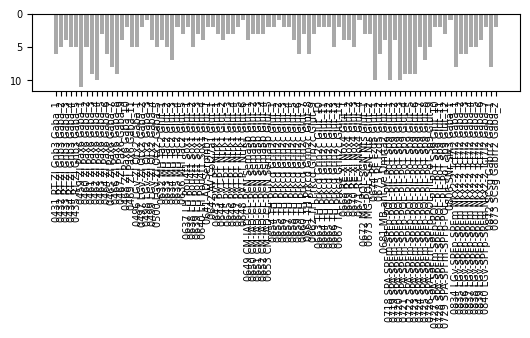

In [12]:
# Count the number of unique clusters per supertype
unique_cluster_df = taxonomy_df_fig1.groupby('supertype', observed=True)['cluster'].nunique().reset_index()
unique_cluster_df.columns = ['supertype', 'unique_cluster_count']

# Plot histogram of unique clusters per supertype 
fig, ax = plt.subplots(figsize=(6.3, 1))
plt.bar(unique_cluster_df['supertype'], 
        unique_cluster_df['unique_cluster_count'], 
        color='darkgrey')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
ax.invert_yaxis()

fig.savefig(f'{results_dir}/fig1A_hist_cluster_count_per_supertype.pdf',
            transparent=True, bbox_inches='tight')

### Colored markers for supertype nodes (histogram xlabels)

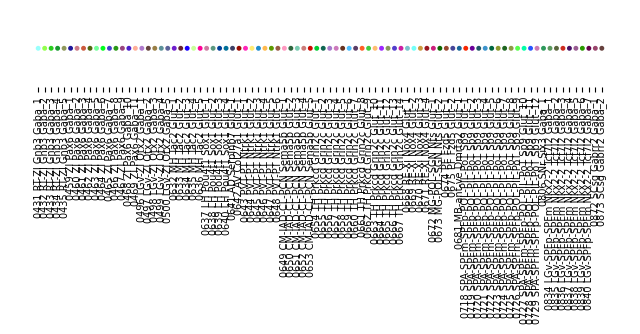

In [13]:
def plot_scatter_xlabel_colors(x_names, x_order, color_dict, xticklabel_is_id=True):
    """Plot a single-row scatter plot with colored markers for each x label.

    Parameters
    ----------
    x_names: list
        list of all possible x-labels
    x_order: np.ndarray
        indices of the items in x_names to plot, in desired order
    color_dict: dict
        dictionary mapping x-labels to colors

    Returns
    -------
    fig: matplotlib.figure.Figure
    """
    # Reorder & subset x_names according to x_order
    x_labels = np.array(x_names)[x_order]
    # Create a list of colors for each x-label
    color_list = [color_dict[x] for x in x_labels if x in color_dict]

    # HARDCODED: use only the taxonomy category ID # for the xticklabels
    if xticklabel_is_id:
        xticklabels = [label.split(" ")[0] for label in x_labels]
    else:
        xticklabels = x_labels

    # fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(8, 1))

    # Plot circular markers at the specified x positions
    ax.scatter(range(len(xticklabels)), 
               np.zeros(len(xticklabels)), 
               c=color_list, 
               s=50, 
               marker='.',
               linewidth=0,
            )

    # Set xticks and labels
    ax.set_xticks(range(len(xticklabels)))
    ax.set_xticklabels(xticklabels, rotation=90)

    # Hide y-axis
    ax.set_frame_on(False)
    ax.get_yaxis().set_visible(False)

    return fig

# Plot xlabel colored markers for each supertype
supertype_color_dict = dict(zip(taxonomy_df_fig1['supertype'], 
                                taxonomy_df_fig1['supertype_color']
                                )
                            )
st_names = unique_cluster_df['supertype'].to_list()
st_order = np.arange(len(st_names))
xlabel_color_marker_fig = plot_scatter_xlabel_colors(st_names, 
                                                     st_order, 
                                                     supertype_color_dict, 
                                                     xticklabel_is_id=False)
xlabel_color_marker_fig.savefig(f'{results_dir}/fig1A_supertype_color_markers.pdf',
                                transparent=True, bbox_inches='tight')

In [14]:
# How many classes, subclasses, supertypes, and clusters are displayed in the figure?
for level in ['class', 'subclass','supertype','cluster']:
    plural_str = 'es' if level[-1] == 's' else 's'
    print(f'Number of unique {level}{plural_str}:', len(taxonomy_df_fig1[level].unique()))

Number of unique classes: 5
Number of unique subclasses: 18
Number of unique supertypes: 88
Number of unique clusters: 388


## Fig. 1B | ARA anatomical annotations 

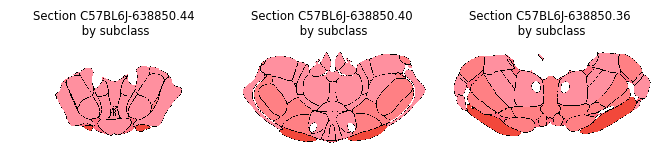

In [15]:
kwargs = dict(
    bg_cells=None,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    point_size=0,
    edge_color="black",
    boundary_img=ccf_boundaries,
    # custom_xy_lims=[2.5, 6, 7, 4],
)

figs_ara = cplots.plot_ccf_overlay(
    obs_th.iloc[:1,:],
    ccf_images,
    point_hue="subclass",
    face_palette=ccf_palette, 
    min_group_count=0,
    sections=cplots.TH_EXAMPLE_SECTION_LABELS,
    separate_figs=False,
    figsize=(20, 5),
    legend=None,
    **kwargs,
)
figs_ara[0].set_size_inches(8.3, 3)
figs_ara[0].savefig(f'{results_dir}/fig1B_ccf_ara.png',
                 transparent=True, bbox_inches='tight', dpi=1200)

### Fig. 1C | TH+ZI cell types

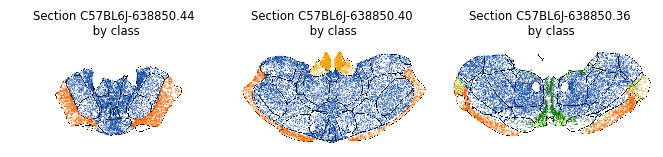

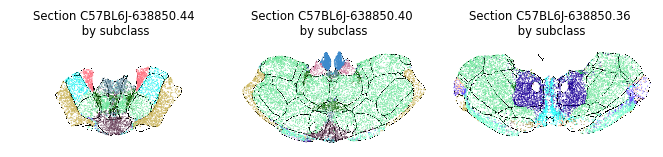

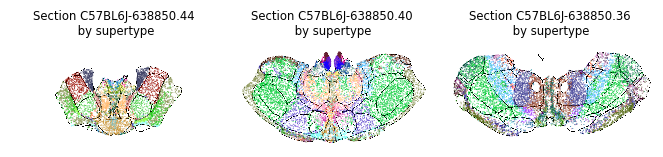

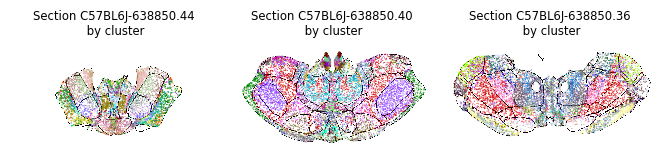

In [16]:
kwargs_celltypes = dict(boundary_img=ccf_boundaries,
                        bg_cells=None,#obs_wmb, # background cells are displayed in grey
                        section_col=section_col,
                        x_col=x_col, 
                        y_col=y_col,
                        edge_color='black',
                        point_size=0.5, # cell marker size
                       )

levels = ['class', 'subclass', 'supertype', 'cluster']

for i, taxonomy_level in enumerate(levels):
    palette = abc_palettes[taxonomy_level]
        
    figs_ccf_celltypes = cplots.plot_ccf_overlay(
        obs_th, 
        ccf_images, 
        point_hue=taxonomy_level, 
        sections=cplots.TH_EXAMPLE_SECTION_LABELS,
        separate_figs=False,
        point_palette=palette,
        legend=None, #'cells',
        figsize=(20, 5),
        **kwargs_celltypes
    )
    
    figs_ccf_celltypes[0].set_size_inches(8.3, 3)
    
    # figs_ccf_celltypes[0].savefig(f'{results_dir}/fig1C_ccf_{taxonomy_level}.pdf',
    #                               transparent=True, bbox_inches='tight', dpi=1200)
    figs_ccf_celltypes[0].savefig(f'{results_dir}/fig1C_ccf_{taxonomy_level}.png',
                                  transparent=True, bbox_inches='tight', dpi=1200)